# Which borough has the most noise complaints (or, more selecting data)

## Install

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

✅ The installed version of syft==0.8.2b2 matches the requirement >=0.8.2b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-3", port=7083, reset=True)

Starting pandas-test-domain-3 server on 0.0.0.0:7083


Waiting for server to start Done.


# Data owner: upload data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-3 as <info@openmined.org>


In [5]:
# The usual preamble
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from syft import Worker, MessageStatus
from syft.service.project.project import Project
from syft.util.util import PANDAS_DATA

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [6]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [7]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

In [8]:
assert len(complaints) == 111069

## Create Mock data

In [9]:
from syft.serde.mock import CachedFaker
from random import randint
import random

Let's create the mock data for the complaint dataset.

In [10]:
fake = CachedFaker()

In [11]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [12]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [13]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [14]:
mock = pd.DataFrame(data=mock_data)

In [15]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,223650,1988-06-09 11:45:51,2002-11-16 10:15:00,DOHMH,Greg Alexander,Noise - Street/Sidewalk,Broken Fence,Cafeteria - College/University,36247,"80057 Walker Mountain\nWest Penny, NC 06440",James Turner,Rogers Roads,Rogers Roads,Payne Ramp,Ashley Plains,ADDRESS,South Danielleland,LINCOLN CENTER,School,Open,1982-01-03 01:12:47,1987-04-16 02:46:54,Unspecified STATEN ISLAND,QUEENS,578703,640159,Jamie King,QUEENS,Kevin Jackson,B111,Region 6,21K226,7187201010,"341 Graham Freeway\nJohnmouth, RI 33416",ASTORIA,Unspecified,31626,NaN,NaN,Car Service,STATEN ISLAND,JFK Airport,Staten Island Expwy,Southbound/To OuterBr Cr,Roadway,Grand Central Pkwy (Exit 1 E-W),Flatbush/Caton Field,NaN,Austen,91.711116,-130.717920,"(-24.929879, -123.653277)"
1,631297,2019-09-22 08:28:25,1979-09-24 11:52:35,NYPD,Tracy Brown,'Animal in a Park',Broken Fence,Vehicle Lane,71268,"78718 Miguel Ways Apt. 062\nBooneton, LA 41645",Jason Garcia,Troy Courts,Mathew Squares,Wheeler Rest,Nguyen Oval,BLOCKFACE,Garciachester,JACKIE ROBINSON PARK,NaN,Pending,1985-02-27 10:39:36,1982-01-03 01:12:47,04 BROOKLYN,STATEN ISLAND,988190,49575,Katie Olsen,STATEN ISLAND,Lori Long,B111,Region 3,01M361,2124472020,"93373 Debra Common Suite 256\nSmithland, AK 21212",ROSEDALE,NY,72133,NaN,NaN,Car Service,BROOKLYN,Intersection,Van Wyck Expwy,North Bound,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Flushing #1 Field,Staten Island Bound,MARIE THEANO,-85.788331,13.441499,"(-36.724659, 91.711116)"
2,20753,1983-07-25 03:06:56,1987-11-07 18:01:12,DOHMH,Mary Ruiz,'Animal in a Park',Broken Glass,Other (explain in Complaint Details),51177,"699 Humphrey Falls Apt. 112\nPort Carrie, LA 3...",Brian Gilbert,Felicia Rest,Banks Cliff,Janice View,Schmidt Well,INTERSECTION,Christopherhaven,BARCLAYS CENTER,NaN,Email Sent,1978-12-27 20:25:24,2017-01-12 05:29:59,03 BRONX,QUEENS,112474,885226,Edward Freeman,STATEN ISLAND,Kevin Jackson,B109,Region 4,28Q072,2122553705,"823 Sawyer Trail\nElizabethhaven, NC 63189",SPRINGFIELD GARDENS,NY,32519,Y,NaN,NaN,QUEENS,New York-Penn Station,Eastern Blvd Br - Edgewater Rd,South/New Jersey Bound,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Bayside Field,Manhattan Bound,JUNE AGARRATT,22.999213,-136.272950,"(13.441499, -8.940573)"
3,936304,1984-05-12 00:51:58,1999-09-18 19:25:56,DOHMH,Leslie Shaw,'Animal in a Park',Branches Damaged,Pier,51549,"823 Sawyer Trail\nElizabethhaven, NC 63189",Adrian Bowman,Nathaniel Ville,Tony Turnpike,Dillon Drive,Ruiz Causeway,NaN,New Marychester,GRAND ARMY PLAZA,Precinct,Pending,2021-10-15 11:03:51,1983-10-08 08:25:14,09 BRONX,QUEENS,94069,60419,Chad Cook,QUEENS,Teresa Joseph,B109,NaN,19K273,2123603444,"741 Mitchell Turnpike Apt. 189\nNorth Aaron, F...",WOODSIDE,NY,46252,N,NaN,Ambulette / Paratransit,BRONX,JFK Airport,Henry Hudson Pkwy/Rt 9A,North/Westbound (To GW Br),Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,White Plains Road Field,Staten Island Bound,JUNE AGARRATT,-90.964166,2.549467,"(79.330026, 123.538000)"
4,377465,2004-01-06 09:26:20,2001-02-10 17:31:00,DOHMH,Patricia Mcclure,Noise - Street/Sidewalk,Broken Fence,Store/Commercial,62542,78095 Kimberly Skyway Suite 391\nNorth Douglas...,Dennis Murillo,Janice View,Sherman Wells,Glenn Viaduct,

In [16]:
dataset = sy.Dataset(name="bikes",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|██████████| 1/1 [00:09<00:00,  9.49s/it]

100%|██████████| 1/1 [00:09<00:00,  9.50s/it]

**WARNING**: The total size for asset: 'complaints' exceeds '512 MB'. This might result in failure to upload dataset. Please contact #support on OpenMined slack for further assistance.


<class 'syft.service.response.SyftSuccess'>: Dataset uploaded to 'pandas-test-domain-3'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

## Create data scientist

In [17]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-3 as <jane@caltech.edu>


# Data scientist: Create syft_function

## Download mock and submit project

### Get mock

In [18]:
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-3 as <jane@caltech.edu>


In [19]:
ds = guest_domain_client.datasets[0]

In [20]:
asset = ds.assets["complaints"]

In [21]:
complaints = asset.mock

### Selecting only noise complaints


I'd like to know which borough has the most noise complaints. First, we'll take a look at the data to see what it looks like:

In [22]:
complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,223650,1988-06-09 11:45:51,2002-11-16 10:15:00,DOHMH,Greg Alexander,Noise - Street/Sidewalk,Broken Fence,Cafeteria - College/University,36247,"80057 Walker Mountain\nWest Penny, NC 06440",James Turner,Rogers Roads,Rogers Roads,Payne Ramp,Ashley Plains,ADDRESS,South Danielleland,LINCOLN CENTER,School,Open,1982-01-03 01:12:47,1987-04-16 02:46:54,Unspecified STATEN ISLAND,QUEENS,578703,640159,Jamie King,QUEENS,Kevin Jackson,B111,Region 6,21K226,7187201010,"341 Graham Freeway\nJohnmouth, RI 33416",ASTORIA,Unspecified,31626,None,NaN,Car Service,STATEN ISLAND,JFK Airport,Staten Island Expwy,Southbound/To OuterBr Cr,Roadway,Grand Central Pkwy (Exit 1 E-W),Flatbush/Caton Field,None,Austen,91.711116,-130.717920,"[-24.929879, -123.653277]"
1,631297,2019-09-22 08:28:25,1979-09-24 11:52:35,NYPD,Tracy Brown,'Animal in a Park',Broken Fence,Vehicle Lane,71268,"78718 Miguel Ways Apt. 062\nBooneton, LA 41645",Jason Garcia,Troy Courts,Mathew Squares,Wheeler Rest,Nguyen Oval,BLOCKFACE,Garciachester,JACKIE ROBINSON PARK,None,Pending,1985-02-27 10:39:36,1982-01-03 01:12:47,04 BROOKLYN,STATEN ISLAND,988190,49575,Katie Olsen,STATEN ISLAND,Lori Long,B111,Region 3,01M361,2124472020,"93373 Debra Common Suite 256\nSmithland, AK 21212",ROSEDALE,NY,72133,None,NaN,Car Service,BROOKLYN,Intersection,Van Wyck Expwy,North Bound,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Flushing #1 Field,Staten Island Bound,MARIE THEANO,-85.788331,13.441499,"[-36.724659, 91.711116]"
2,20753,1983-07-25 03:06:56,1987-11-07 18:01:12,DOHMH,Mary Ruiz,'Animal in a Park',Broken Glass,Other (explain in Complaint Details),51177,"699 Humphrey Falls Apt. 112\nPort Carrie, LA 3...",Brian Gilbert,Felicia Rest,Banks Cliff,Janice View,Schmidt Well,INTERSECTION,Christopherhaven,BARCLAYS CENTER,None,Email Sent,1978-12-27 20:25:24,2017-01-12 05:29:59,03 BRONX,QUEENS,112474,885226,Edward Freeman,STATEN ISLAND,Kevin Jackson,B109,Region 4,28Q072,2122553705,"823 Sawyer Trail\nElizabethhaven, NC 63189",SPRINGFIELD GARDENS,NY,32519,Y,NaN,None,QUEENS,New York-Penn Station,Eastern Blvd Br - Edgewater Rd,South/New Jersey Bound,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Bayside Field,Manhattan Bound,JUNE AGARRATT,22.999213,-136.272950,"[13.441499, -8.940573]"
3,936304,1984-05-12 00:51:58,1999-09-18 19:25:56,DOHMH,Leslie Shaw,'Animal in a Park',Branches Damaged,Pier,51549,"823 Sawyer Trail\nElizabethhaven, NC 63189",Adrian Bowman,Nathaniel Ville,Tony Turnpike,Dillon Drive,Ruiz Causeway,None,New Marychester,GRAND ARMY PLAZA,Precinct,Pending,2021-10-15 11:03:51,1983-10-08 08:25:14,09 BRONX,QUEENS,94069,60419,Chad Cook,QUEENS,Teresa Joseph,B109,None,19K273,2123603444,"741 Mitchell Turnpike Apt. 189\nNorth Aaron, F...",WOODSIDE,NY,46252,N,NaN,Ambulette / Paratransit,BRONX,JFK Airport,Henry Hudson Pkwy/Rt 9A,North/Westbound (To GW Br),Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,White Plains Road Field,Staten Island Bound,JUNE AGARRATT,-90.964166,2.549467,"[79.330026, 123.538000]"
4,377465,2004-01-06 09:26:20,2001-02-10 17:31:00,DOHMH,Patricia Mcclure,Noise - Street/Sidewalk,Broken Fence,Store/Commercial,62542,78095 Kimberly Skyway Suite 391\nNorth Douglas...,Dennis Murillo,Janice View,Sherman Wells,Glenn 

To get the noise complaints, we need to find the rows where the "Complaint Type" column is "Noise - Street/Sidewalk". I'll show you how to do that, and then explain what's going on.



In [23]:
noise_complaints = complaints[complaints['Complaint Type'] == "Noise - Street/Sidewalk"]
noise_complaints[:3]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,223650,1988-06-09 11:45:51,2002-11-16 10:15:00,DOHMH,Greg Alexander,Noise - Street/Sidewalk,Broken Fence,Cafeteria - College/University,36247,"80057 Walker Mountain\nWest Penny, NC 06440",James Turner,Rogers Roads,Rogers Roads,Payne Ramp,Ashley Plains,ADDRESS,South Danielleland,LINCOLN CENTER,School,Open,1982-01-03 01:12:47,1987-04-16 02:46:54,Unspecified STATEN ISLAND,QUEENS,578703,640159,Jamie King,QUEENS,Kevin Jackson,B111,Region 6,21K226,7187201010,"341 Graham Freeway\nJohnmouth, RI 33416",ASTORIA,Unspecified,31626,None,NaN,Car Service,STATEN ISLAND,JFK Airport,Staten Island Expwy,Southbound/To OuterBr Cr,Roadway,Grand Central Pkwy (Exit 1 E-W),Flatbush/Caton Field,None,Austen,91.711116,-130.717920,"[-24.929879, -123.653277]"
4,377465,2004-01-06 09:26:20,2001-02-10 17:31:00,DOHMH,Patricia Mcclure,Noise - Street/Sidewalk,Broken Fence,Store/Commercial,62542,78095 Kimberly Skyway Suite 391\nNorth Douglas...,Dennis Murillo,Janice View,Sherman Wells,Glenn Viaduct,Martinez Union,ADDRESS,Robinsonside,CITI FIELD,School,Email Sent,2012-09-23 09:24:09,2009-07-15 17:17:08,08 QUEENS,BROOKLYN,175497,605797,Timothy Murphy,BROOKLYN,Joseph Smith,B073,Region 7,31R030,2123603444,78095 Kimberly Skyway Suite 391\nNorth Douglas...,CORONA,Unspecified,08278,Y,NaN,Car Service,BROOKLYN,None,Henry Hudson Pkwy/Rt 9A,Southbound,Roadway,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Ave M Field,Manhattan Bound,None,-123.653277,0.418522,"[-62.450887, -24.929879]"
9,968349,2006-10-05 08:05:23,1985-06-06 17:40:24,NYPD,Christopher Myers,Noise - Street/Sidewalk,Broken Fence,1-3 Family Dwelling,15990,Unit 9055 Box 2200\nDPO AE 52978,Matthew Contreras,Miller Fort,Madison Trail,Chris Forks,Barbara Stravenue,PLACENAME,New Matthewbury,WASHINGTON SQUARE PARK,School,Started,1995-02-06 08:50:28,2017-07-23 17:39:10,05 BROOKLYN,QUEENS,75173,98913,Stuart Banks,STATEN ISLAND,Kevin Jackson,B109,Region 7,21K226,2125006035,"943 Matthew Valleys\nLisaland, ME 82714",EAST ELMHURST,Unspecified,51041,None,NaN,None,BROOKLYN,Intersection,Long Island Expwy,Westbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Flushing #3 Field,Manhattan Bound,STEIN SENIOR CENTER,137.176910,-61.010040,"[42.049434, 107.059596]"


If you look at noise_complaints, you'll see that this worked, and it only contains complaints with the right complaint type. But how does this work? Let's deconstruct it into two pieces

In [24]:
complaints['Complaint Type'] == "Noise - Street/Sidewalk"

0          True
1         False
2         False
3         False
4          True
          ...  
111064    False
111065    False
111066    False
111067    False
111068    False
Name: Complaint Type, Length: 111069, dtype: bool

This is a big array of Trues and Falses, one for each row in our dataframe. When we index our dataframe with this array, we get just the rows where our boolean array evaluated to True. It's important to note that for row filtering by a boolean array the length of our dataframe's index must be the same length as the boolean array used for filtering.

You can also combine more than one condition with the & operator like this:

In [25]:
is_noise = (complaints['Complaint Type'] == "Noise - Street/Sidewalk")
in_brooklyn = complaints['Borough'] == "BROOKLYN"
complaints[is_noise & in_brooklyn][:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
4,377465,2004-01-06 09:26:20,2001-02-10 17:31:00,DOHMH,Patricia Mcclure,Noise - Street/Sidewalk,Broken Fence,Store/Commercial,62542,78095 Kimberly Skyway Suite 391\nNorth Douglas...,Dennis Murillo,Janice View,Sherman Wells,Glenn Viaduct,Martinez Union,ADDRESS,Robinsonside,CITI FIELD,School,Email Sent,2012-09-23 09:24:09,2009-07-15 17:17:08,08 QUEENS,BROOKLYN,175497,605797,Timothy Murphy,BROOKLYN,Joseph Smith,B073,Region 7,31R030,2123603444,78095 Kimberly Skyway Suite 391\nNorth Douglas...,CORONA,Unspecified,08278,Y,NaN,Car Service,BROOKLYN,None,Henry Hudson Pkwy/Rt 9A,Southbound,Roadway,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Ave M Field,Manhattan Bound,None,-123.653277,0.418522,"[-62.450887, -24.929879]"
74,550146,2012-07-08 08:36:48,1999-05-12 01:36:39,DPR,James King,Noise - Street/Sidewalk,Broken Glass,Store,87118,"83236 Burns Plains Suite 875\nCoxland, AZ 63024",Michele Gray,Ashley Plains,Miller Fort,Chavez Center,Shannon Keys,BLOCKFACE,Port Miguelton,LINCOLN CENTER,None,Closed,2019-11-29 07:50:07,1972-08-30 19:48:45,07 BRONX,BROOKLYN,428472,74468,Jason Garcia,Unspecified,Jared Scott,B111,Region 5,75K373,7182631163,"957 Jackson Pike\nPort Melissamouth, LA 40154",Unspecified,NY,45868,N,NaN,Commuter Van,STATEN ISLAND,Intersection,First Ave Tunnel - UN Plaza,West/Staten Island Bound,None,Grand Central Pkwy (Exit 1 E-W),Grant Ave Field,Staten Island Bound,BRIGID OCONNOR,-14.826237,-148.516276,"[51.046892, 40.768233]"
97,921892,1978-10-16 07:21:26,1999-09-18 19:25:56,DPR,Christian Moore,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Pier,81930,"75787 Copeland Hill\nWest Kellystad, WV 75983",Jennifer Simmons,Peck Dale,Mathew Squares,Barry Locks,Crystal Fords,BLOCKFACE,Lake Jasonmouth,JFK,DSNY Garage,Unassigned,1985-01-30 21:11:55,2008-06-08 11:31:28,55 BROOKLYN,BROOKLYN,239396,27463,Jose Simpson,QUEENS,Mary Richards,B080-01,None,03M009,7183184000,"46420 Hodge Plaza Apt. 375\nNew Lauraland, AL ...",BAYSIDE,Unspecified,41091,None,NaN,Ambulette / Paratransit,QUEENS,None,Alexander Hamilton/I-95 Cross Bronx Br,South/East (To Throgs Neck Br),None,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Far Rockaway #2 Field,Staten Island Bound,JEWISH ASSOCIATION FOR SERVICES FOR THE AGED (...,107.334882,-177.505007,"[-80.693528, -90.964166]"
103,840414,2000-01-14 18:07:00,1985-06-06 17:40:24,NYPD,Rick Evans,Noise - Street/Sidewalk,Branches Damaged,Street and Sidewalk,08068,"66548 Colleen Estate Apt. 964\nHollowayburgh, ...",William Huerta,Martinez Union,Kimberly Green,Carter Coves,Davis Canyon,None,South Luisport,GRAND CENTRAL TERM,School,Email Sent,1978-10-16 07:21:26,2017-01-22 19:18:59,06 QUEENS,BROOKLYN,558877,742075,Adrian Park,Unspecified,Tiffany Berg,B073,Region 7,15K015,7189658999,"779 Benson Key\nJoanneshire, AZ 96489",CORONA,Unspecified,13352,Y,NaN,Commuter Van,BROOKLYN,Grand Central Station,FDR Dr,North/Westchester County Bound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Flatbush/Caton Field,Staten Island Bound,MITCHELL HOUSES SENIOR CENTER,69.979999,-31.308629,"[109.126279, -10.970035]"
114,500297,2016-02-28 00:51:46,2017-01-22 19:18:59,NYPD,Mitchell Owens,Noise - Street/Sidewalk,Branches Damaged,Residential,70101,"705 Torr

Or if we just wanted a few columns:



In [26]:
complaints[is_noise & in_brooklyn][['Complaint Type', 'Borough', 'Created Date', 'Descriptor']][:10]

,Complaint Type,Borough,Created Date,Descriptor
4,Noise - Street/Sidewalk,BROOKLYN,2004-01-06 09:26:20,Broken Fence
74,Noise - Street/Sidewalk,BROOKLYN,2012-07-08 08:36:48,Broken Glass
97,Noise - Street/Sidewalk,BROOKLYN,1978-10-16 07:21:26,Branch or Limb Has Fallen Down
103,Noise - Street/Sidewalk,BROOKLYN,2000-01-14 18:07:00,Branches Damaged
114,Noise - Street/Sidewalk,BROOKLYN,2016-02-28 00:51:46,Branches Damaged
124,Noise - Street/Sidewalk,BROOKLYN,1976-11-02 17:27:54,Branch or Limb Has Fallen Down
126,Noise - Street/Sidewalk,BROOKLYN,1986-02-28 12:31:37,Broken Fence
136,Noise - Street/Sidewalk,BROOKLYN,1983-10-08 08:25:14,Broken Glass
194,Noise - Street/Sidewalk,BROOKLYN,1988-11-24 12:23:35,Branch or Limb Has Fallen Down
199,Noise - Street/Sidewalk,BROOKLYN,1984-05-12 00:51:58,Broken Glass


### A digression about numpy arrays

On the inside, the type of a column is pd.Series

In [27]:
import pandas as pd
import numpy as np

In [28]:
pd.Series([1,2,3])

0    1
1    2
2    3
dtype: int64

and pandas Series are internally numpy arrays. If you add .values to the end of any Series, you'll get its internal numpy array

In [29]:
np.array([1,2,3])

array([1, 2, 3])

In [30]:
pd.Series([1,2,3]).values

array([1, 2, 3])

So this binary-array-selection business is actually something that works with any numpy array:

In [31]:
arr = np.array([1,2,3])

In [32]:
arr != 2

array([ True, False,  True])

In [33]:
arr[arr != 2]

array([1, 3])

### So, which borough has the most noise complaints?

In [34]:
is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
noise_complaints = complaints[is_noise]
noise_complaints['Borough'].value_counts()

BROOKLYN         6263
Unspecified      6258
STATEN ISLAND    6223
MANHATTAN        6202
BRONX            6171
QUEENS           6134
Name: Borough, dtype: int64

It's the BRONX (for this Mock)! But what if we wanted to divide by the total number of complaints, to make it make a bit more sense? That would be easy too:

In [35]:
noise_complaint_counts = noise_complaints['Borough'].value_counts()
complaint_counts = complaints['Borough'].value_counts()

In [36]:
noise_complaint_counts

BROOKLYN         6263
Unspecified      6258
STATEN ISLAND    6223
MANHATTAN        6202
BRONX            6171
QUEENS           6134
Name: Borough, dtype: int64

In [37]:
noise_complaint_counts / complaint_counts

BRONX            0.333117
BROOKLYN         0.338157
MANHATTAN        0.332940
QUEENS           0.334278
STATEN ISLAND    0.334642
Unspecified      0.339205
Name: Borough, dtype: float64

Oops, why was that zero? That's no good. This is because of integer division in Python 2. Let's fix it, by converting complaint_counts into an array of floats.

In [38]:
noise_complaint_counts / complaint_counts.astype(float)

BRONX            0.333117
BROOKLYN         0.338157
MANHATTAN        0.332940
QUEENS           0.334278
STATEN ISLAND    0.334642
Unspecified      0.339205
Name: Borough, dtype: float64

<Axes: >

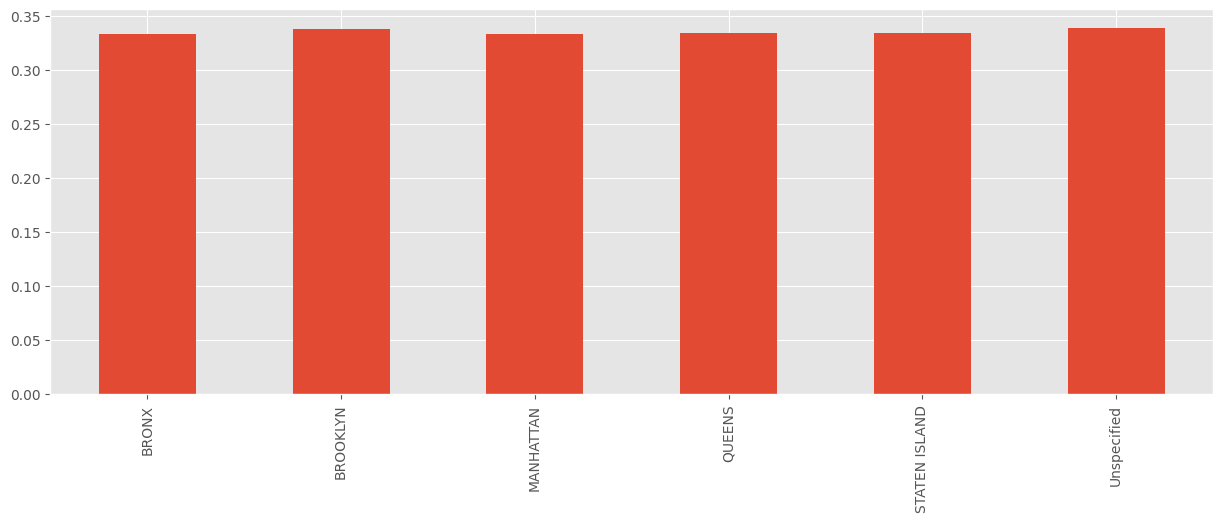

In [39]:
(noise_complaint_counts / complaint_counts.astype(float)).plot(kind='bar')

So Bronx really does complain more about noise than the other boroughs in our mock! Neat.

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [40]:
@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.pointer),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)

Syft function 'get_counts' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


Create and submit project

In [41]:
new_project = sy.Project(
    name="Pandas chapter 3",
    description="Hi, I would like to plot the histogram of the noise complaint counts per area.",
    members=[guest_domain_client],
)
new_project

syft.service.project.project.ProjectSubmit

In [42]:
project = new_project.start()
assert isinstance(project, sy.service.project.project.Project)
project

syft.service.project.project.Project

In [43]:
project.create_code_request(get_counts, guest_domain_client)

<class 'syft.service.response.SyftSuccess'>: Code request for 'get_counts' successfully added to 'Pandas chapter 3' Project. To see code requests by a client, run `[your_client].code`

In [44]:
assert len(guest_domain_client.code.get_all())==1

In [45]:
assert len(project.events) == 1

In [46]:
assert isinstance(project.events[0], sy.service.project.project.ProjectRequest)

# Data owner: execute function

## Get messages

In [47]:
domain_client = node.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-3 as <info@openmined.org>


In [48]:
messages = domain_client.api.services.messages.get_all_unread()

In [49]:
messages

[syft.service.message.messages.Message, syft.service.message.messages.Message]

In [50]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [51]:
request = project_message.link.events[0].request
func = request.changes[0].link
op = func.output_policy_type

In [52]:
func

```python
class UserCode
    id: str = ad8f2ed825384c2fa6196dff912abd83
    status.approved: str = False
    service_func_name: str = get_counts
    code:

@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.pointer),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)

```

In [53]:
get_counts_user_func = func.unsafe_function

In [54]:
real_data = domain_client.datasets[0].assets[0].data

In [55]:
real_result = get_counts_user_func(complaints=real_data)

In [56]:
real_result[:3]

BRONX        0.014833
BROOKLYN     0.013864
MANHATTAN    0.037755
Name: Borough, dtype: float64

In [57]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [58]:
asset = guest_client.datasets[0].assets[0]

In [59]:
guest_client.code[0].status

{NodeView(node_name='pandas-test-domain-3', verify_key=c5accc4b2c4d5cafc32f09cfd91669d43a607c7cabdc4f0f05093754fa4a5bdc): <UserCodeStatus.EXECUTE: 'execute'>}

<Axes: >

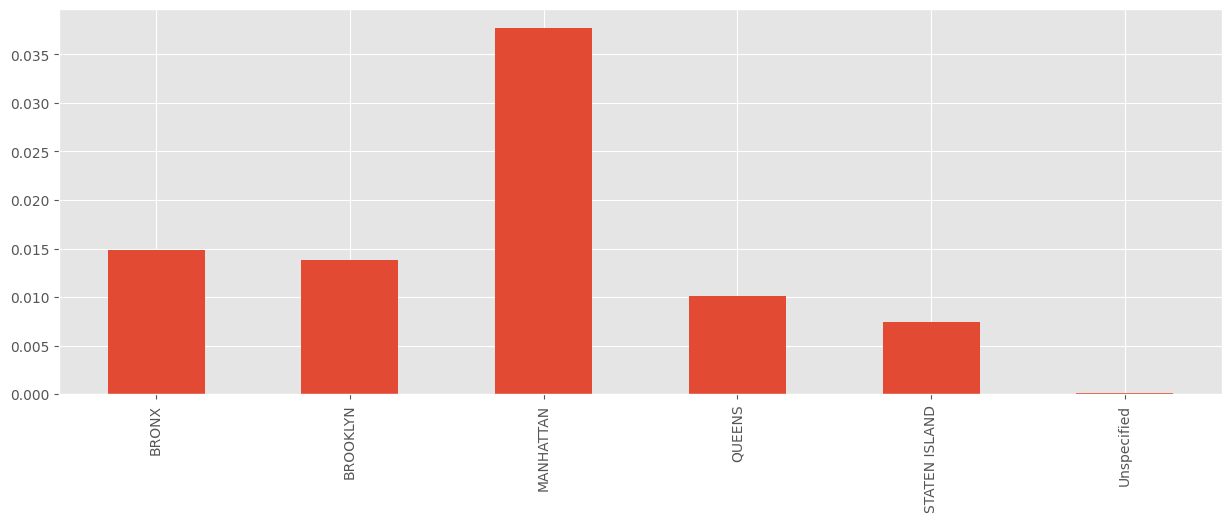

In [60]:
result_ptr = guest_client.code.get_counts(complaints=asset)
real_result = result_ptr.get()
real_result.plot(kind="bar")

In [61]:
node.land()

Stopping pandas-test-domain-3
